In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
baslik_font = {'family': 'arial', 'color': 'darkred','weight': 'bold','size': 13 }
eksen_font  = {'family': 'arial', 'color': 'darkblue','weight': 'bold','size': 10 }

1.Sınav sonuçları normal dağılımlı mıdır? Değilse normal dağılıma sahip hale getirmek için ne yapabiliriz?

2.Üç sınav sonucunu tek bir değişkende, hedef değişkeni olarak tutmak istiyoruz. Bunun için üç sınavın ortalamasını içeren yeni bir değişken tanımlayın. Bu yeni değişkenin ortalamasının normal dağılımlı olup olmadığını test edin. Eğer normal dağılıma sahip değilse dönüşüm yaparak normal dağılımlı hale getirmeye çalışın ve dönüşümün sonucunu test edin.

3.Bir önceki soruda oluşturduğumuz hedef değişkeni ile hangi değişkenler ilişkili görünüyor? Eğer amacımız sınav başarısını belirleyen etkenleri açıklamak olsaydı hangi değişkenleri veri kümemizde tutmamız gerekirdi?



In [3]:
student_performance = pd.read_csv("StudentsPerformance.csv")
student_performance.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


1.Sınav sonuçları normal dağılımlı mıdır? Değilse normal dağılıma sahip hale getirmek için ne yapabiliriz?


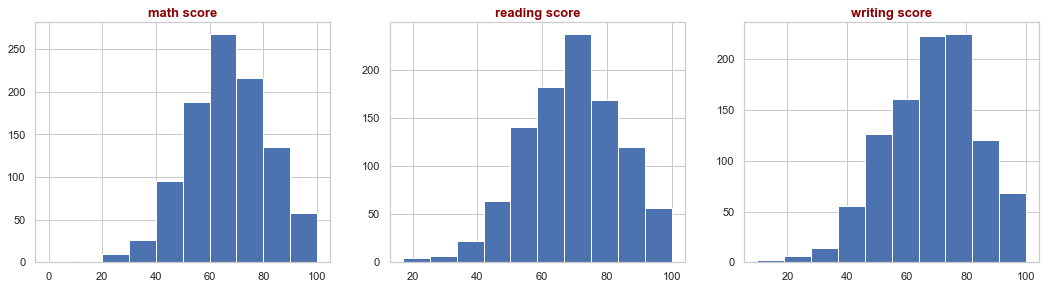

In [6]:
#Dagilim grafigine bakarak normal dagilim kontrolu:

plt.figure(figsize=(18,15))

plt.subplot(3, 3, 1)
plt.hist(student_performance['math score'])
plt.title('math score', fontdict=baslik_font)
    
plt.subplot(3, 3, 2)
plt.hist(student_performance['reading score'])
plt.title('reading score', fontdict=baslik_font)
    
plt.subplot(3, 3, 3)
plt.hist(student_performance['writing score'])
plt.title('writing score', fontdict=baslik_font)

plt.show()


In [7]:
# log dönüştürülmüş değişkenlerin dağılımlarının scipy modülündeki Jarque-Bera ve Normal testlerini kullanarak
#hala normal dağılımı takip etmediğini istatistiksel olarak doğrulayabiliriz:

from scipy.stats import jarque_bera
from scipy.stats import normaltest

pd.options.display.float_format = '{:.5f}'.format

ozellikler = ["math score","reading score", "writing score"]
dagilim_testleri = pd.DataFrame(columns=['ozellik', 'jarque_bera_stats', 'jarque_bera_p_value', 
                                         'normal_stats', 'normal_p_value'])

for ozellik in ozellikler:
    jb_stats = jarque_bera(np.log(student_performance[ozellik]))
    norm_stats = normaltest(np.log(student_performance[ozellik]))
    dagilim_testleri = dagilim_testleri.append({"ozellik": ozellik,
                                                "jarque_bera_stats" : jb_stats[0] ,
                                                "jarque_bera_p_value" : jb_stats[1] ,
                                                "normal_stats": norm_stats[0] , 
                                                "normal_p_value" : norm_stats[1]
                                               }, ignore_index=True)
dagilim_testleri

,ozellik,jarque_bera_stats,jarque_bera_p_value,normal_stats,normal_p_value
0,math score,nan,nan,nan,nan
1,reading score,495.12732,0.00000,209.77151,0.00000
2,writing score,1410.93701,0.00000,318.96921,0.00000


P degerlerinin 0 oldugunu ve dagilimlarin normal dagilmadigini goruyoruz.


In [11]:
#Math Score degerlerinin nan olarak gelmesi dolayisiyla eksik deger kontrolu:
student_performance["math score"].isnull().sum()/student_performance["math score"].isnull().count()

0.0

In [13]:
#Pandas, bir veri çerçevesindeki her öğe için bir öğenin değeri yoksa (None) veya False ifadesini alırsa, True döndüren .isnull () adlı bir metoda sahiptir.
#Ancak, bu metodu veri çerçevemizden çağırdığımızda, şunu elde ederiz:

student_performance["math score"].isnull().head()

0    False
1    False
2    False
3    False
4    False
Name: math score, dtype: bool

In [15]:
#1.Normalleştirme, bir değişkenin [0,1] aralığına yeniden ölçeklendirilmesidir (0 ve 1 dahil). Bu amaçla, SKLearn kütüphanesinin  preprocessing modülünden .normalize() metodunu kullanacağız. 


from sklearn.preprocessing import normalize

student_performance["norm_math score"] = normalize(np.array(student_performance["math score"]).reshape(1,-1)).reshape(-1,1)
student_performance["norm_reading score"] = normalize(np.array(student_performance["reading score"]).reshape(1,-1)).reshape(-1,1)
student_performance["norm_writing score"] = normalize(np.array(student_performance["writing score"]).reshape(1,-1)).reshape(-1,1)
normal_ozellikler=["math score","norm_math score","reading score","norm_reading score",
                    "writing score","norm_writing score"]


print('Minimum Değer\n-----------------',)
print(student_performance[normal_ozellikler].min())
print('\nMaksimum Değer\n-----------------',)
print(student_performance[normal_ozellikler].max())

Minimum Değer
-----------------
math score            0.00000
norm_math score       0.00000
reading score        17.00000
norm_reading score    0.00760
writing score        10.00000
norm_writing score    0.00454
dtype: float64

Maksimum Değer
-----------------
math score           100.00000
norm_math score        0.04664
reading score        100.00000
norm_reading score     0.04473
writing score        100.00000
norm_writing score     0.04535
dtype: float64


In [16]:
#2.Standartlaştırma, bir değişkenin, ortalaması 0 ve standart sapması 1 olacak şekilde yeniden ölçeklendirilmesidir. Standartlaştırmada değişken için maksimum değer uygulamadığımıza dikkat edin. Standartlaştırmayı uygulamak için,
#SKLearn kütüphanesinin' preprocessing modülünden .scale() metodunu kullanacağız.


from sklearn.preprocessing import scale

student_performance["olcekli_math score"] = scale(student_performance["math score"])
student_performance["olcekli_reading score"] = scale(student_performance["reading score"])
student_performance["olcekli_writing score"] = scale(student_performance["writing score"])
olcekli_ozellikler=["math score","olcekli_math score","reading score",
                    "olcekli_reading score","writing score", "olcekli_writing score"]
print(student_performance[olcekli_ozellikler].std())
print('\nOrtalamalar\n-----------------',)
print(student_performance[olcekli_ozellikler].mean())

math score              15.16308
olcekli_math score       1.00050
reading score           14.60019
olcekli_reading score    1.00050
writing score           15.19566
olcekli_writing score    1.00050
dtype: float64

Ortalamalar
-----------------
math score              66.08900
olcekli_math score       0.00000
reading score           69.16900
olcekli_reading score    0.00000
writing score           68.05400
olcekli_writing score   -0.00000
dtype: float64


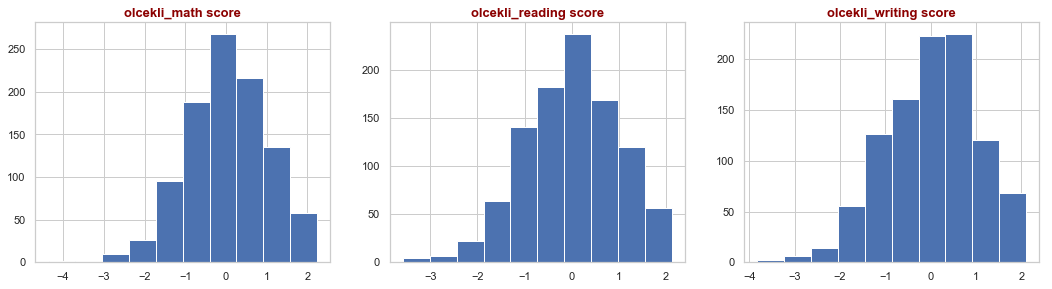

In [17]:
#Dagilim grafigine tekrar bakarak normal dagilim kontrolu yapalim:

plt.figure(figsize=(18,15))

plt.subplot(3, 3, 1)
plt.hist(student_performance['olcekli_math score'])
plt.title('olcekli_math score', fontdict=baslik_font)
    
plt.subplot(3, 3, 2)
plt.hist(student_performance['olcekli_reading score'])
plt.title('olcekli_reading score', fontdict=baslik_font)
    
plt.subplot(3, 3, 3)
plt.hist(student_performance['olcekli_writing score'])
plt.title('olcekli_writing score', fontdict=baslik_font)

plt.show()

Ortalamasi 0 ve standart sapmasi 1 olarak verilerimiz normal dagilima uydu. 

2.Üç sınav sonucunu tek bir değişkende, hedef değişkeni olarak tutmak istiyoruz. Bunun için üç sınavın ortalamasını içeren yeni bir değişken tanımlayın. Bu yeni değişkenin ortalamasının normal dağılımlı olup olmadığını test edin. Eğer normal dağılıma sahip değilse dönüşüm yaparak normal dağılımlı hale getirmeye çalışın ve dönüşümün sonucunu test edin.


In [35]:
hedef_degisken = [ student_performance["math score"].mean(), student_performance["reading score"].mean(),
                  student_performance["writing score"].mean()]
print(hedef_degisken)

[66.089, 69.169, 68.054]


Text(0.5, 1.0, 'hedef_degisken')

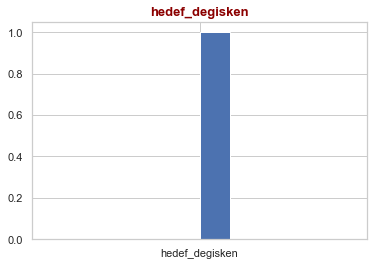

In [25]:
plt.hist('hedef_degisken')
plt.title('hedef_degisken', fontdict=baslik_font)

3.Bir önceki soruda oluşturduğumuz hedef değişkeni ile hangi değişkenler ilişkili görünüyor? Eğer amacımız sınav başarısını belirleyen etkenleri açıklamak olsaydı hangi değişkenleri veri kümemizde tutmamız gerekirdi?

In [31]:
student_performance.corr()

,math score,reading score,writing score,norm_math score,norm_reading score,norm_writing score,olcekli_math score,olcekli_reading score,olcekli_writing score
math score,1.00000,0.81758,0.80264,1.00000,0.81758,0.80264,1.00000,0.81758,0.80264
reading score,0.81758,1.00000,0.95460,0.81758,1.00000,0.95460,0.81758,1.00000,0.95460
writing score,0.80264,0.95460,1.00000,0.80264,0.95460,1.00000,0.80264,0.95460,1.00000
norm_math score,1.00000,0.81758,0.80264,1.00000,0.81758,0.80264,1.00000,0.81758,0.80264
norm_reading score,0.81758,1.00000,0.95460,0.81758,1.00000,0.95460,0.81758,1.00000,0.95460
norm_writing score,0.80264,0.95460,1.00000,0.80264,0.95460,1.00000,0.80264,0.95460,1.00000
olcekli_math score,1.00000,0.81758,0.80264,1.00000,0.81758,0.80264,1.00000,0.81758,0.80264
olcekli_reading score,0.81758,1.00000,0.95460,0.81758,1.00000,0.95460,0.81758,1.00000,0.95460
olcekli_writing score,0.80264,0.95460,1.00000,0.80264,0.95460,1.00000,0.80264,0.95460,1.00000


In [36]:
korelasyon_mat_performance = student_performance.corr()
korelasyon_mat_hedef_degisken = hedef_degisken.corr()
display(korelasyon_mat_performance, korelasyon_mat_hedef_degisken)


AttributeError: 'list' object has no attribute 'corr'